# 📌 Introduction

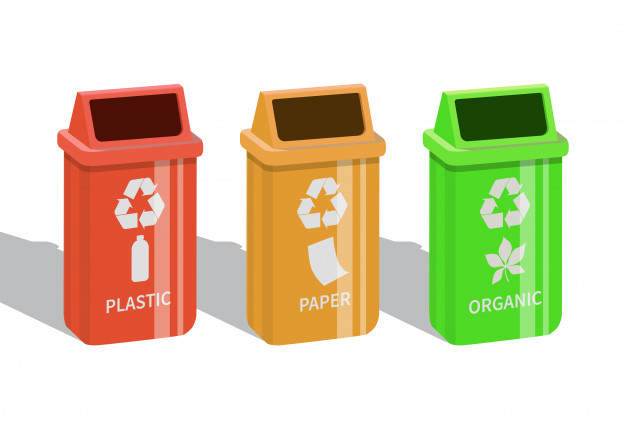

Waste is a significant global issue. Increasing volumes of waste are being generated as the global population and living standards rise. People are increasingly concerned about the production of waste and its effect, and are seeking ways to deal with the problem.

Recycling is the process of converting waste materials into new materials and objects. The recovery of energy from waste materials is often included in this concept. The recyclability of a material depends on its ability to reacquire the properties it had in its original state. It is an alternative to "conventional" waste disposal that can save material and help lower greenhouse gas emissions. Recycling can prevent the waste of potentially useful materials and reduce the consumption of fresh raw materials, thereby reducing: energy usage, air pollution (from incineration), and water pollution (from landfilling).

 **🟢 In this notebook, we will classify waste as organic or recyclable using Convolutional Neural Network (CNN).**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"

## Import Libraries

In [3]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model


In [4]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


## Visualization

* O -> Organic
* R -> Recyclable

# Convolutional Neural Network - CNN

In [5]:
numberOfClass = 2

In [6]:
from tensorflow.keras import layers, models, optimizers

# Build the new model
model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(224,224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(numberOfClass, activation='softmax'),
])

# Compile the model with an adaptive learning rate optimizer
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32


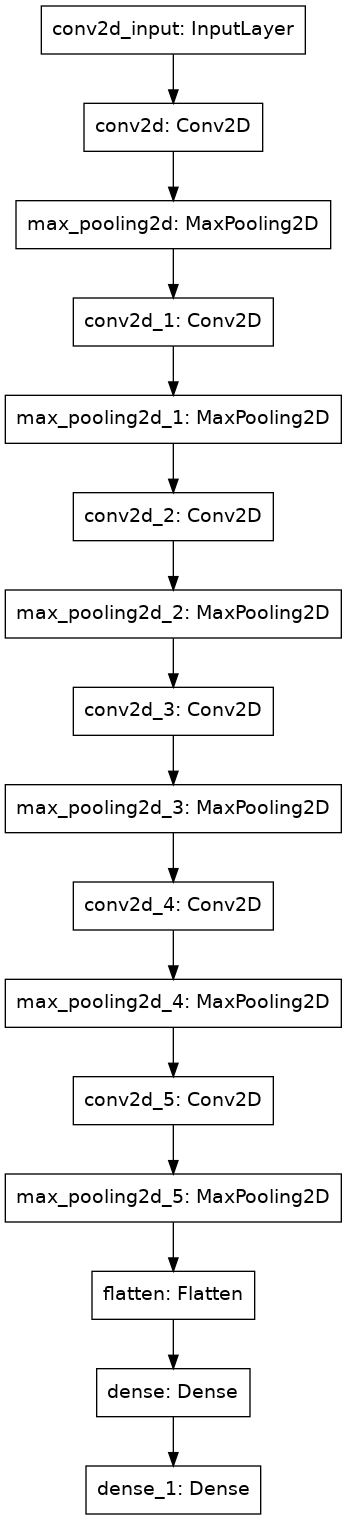

In [7]:
plot_model(model)

In [8]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True)

In [9]:
test_datagen = ImageDataGenerator(rescale= 1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True)

In [10]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.h5',         # Path to save the model
    monitor='val_accuracy',   # Monitor the validation accuracy
    save_best_only=True,      # Save only the best model
    mode='max',               # Save when the monitored quantity is maximized
    verbose=1                 # Display messages when saving the model
)

# Train the model with the checkpoint callback
hist = model.fit_generator(
    generator=train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint]    # Include the callback here
)


Epoch 1/100
706/706 [==============================] - 439s 610ms/step - loss: 0.4982 - accuracy: 0.7675 - val_loss: 0.3966 - val_accuracy: 0.8380

Epoch 00001: val_accuracy improved from -inf to 0.83804, saving model to best_model.h5
Epoch 2/100
706/706 [==============================] - 285s 403ms/step - loss: 0.4236 - accuracy: 0.8162 - val_loss: 0.3166 - val_accuracy: 0.8750

Epoch 00002: val_accuracy improved from 0.83804 to 0.87505, saving model to best_model.h5
Epoch 3/100
706/706 [==============================] - 287s 406ms/step - loss: 0.3763 - accuracy: 0.8463 - val_loss: 0.3196 - val_accuracy: 0.8739

Epoch 00003: val_accuracy did not improve from 0.87505
Epoch 4/100
706/706 [==============================] - 283s 401ms/step - loss: 0.3533 - accuracy: 0.8525 - val_loss: 0.2819 - val_accuracy: 0.8989

Epoch 00004: val_accuracy improved from 0.87505 to 0.89893, saving model to best_model.h5
Epoch 5/100
706/706 [==============================] - 282s 400ms/step - loss: 0.3398 

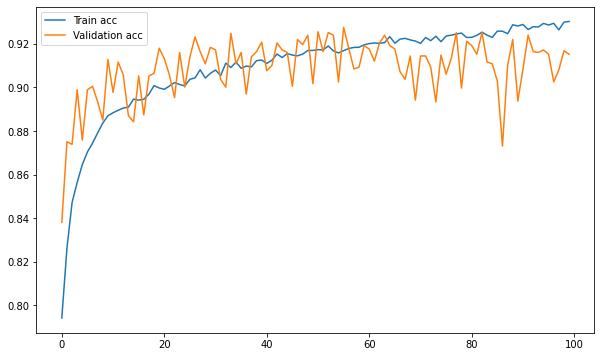

In [12]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

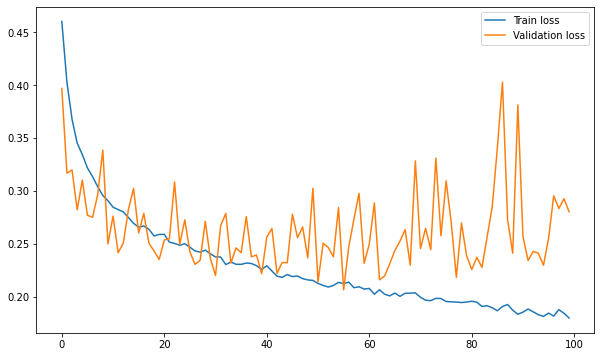

In [13]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## Model Prediction

In [14]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: 
        print("This image is Recyclable.")
    else: 
        print("This image is Organic.")

This image is Organic.


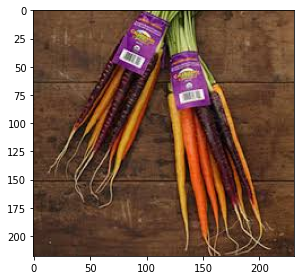

In [15]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

This image is Recyclable.


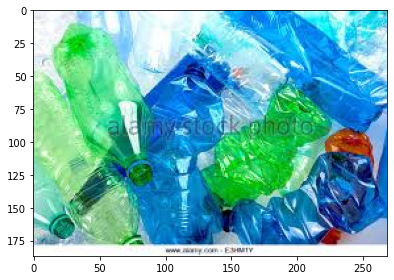

In [16]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TRAIN/R/R_100.jpg")
predict_func(test_img)

In [2]:
model.save('bio_nonbio3.h5')

NameError: name 'model' is not defined